## STAR-RIS Aided Multi-Cell NOMA

### Necessary Imports

In [1]:
import os
import sys

sys.path.append(os.path.abspath(".."))

import matplotlib.pyplot as plt
import numpy as np
import simcomm.metrics as metrics
import simcomm.utils as utils
from simcomm.fading import generate_channel
from simcomm.visualize import plot_network

plt.style.use("default")
plt.rcParams["figure.figsize"] = (6, 4)

os.makedirs("./data/star_ris_mc_noma", exist_ok=True)
save_dir = os.path.abspath("./data/star_ris_mc_noma/")

### System Model

Parameters

In [2]:
# Multi-cell NOMA
N = 3  # Number of users
N_index = np.arange(N)  # Index of users
M = 2  # Number of BSs
M_index = np.arange(M)  # Index of BSs
T = 290  # Temperature in Kelvin
BANDWIDTH = 10e6  # bandwidth in Hz
NOISE = utils.get_noise(BANDWIDTH, T, 43)  # noise power in dBm
NOISE_LIN = utils.dbm2pow(NOISE)  # noise power in linear scale
S = 8000  # Number of monte carlo simulations
K_rice = 3  # Rician factor

# Power parameters
Pt = np.linspace(-40, 20, 120)  # transmit power in dBm
Pt_lin = utils.dbm2pow(Pt)  # transmit power in linear scale
P_circuit = 10e-5  # circuit power in Watts

Creating Layout

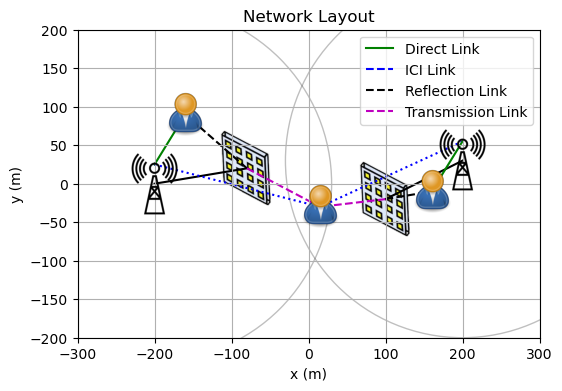

In [3]:
bs_pos = np.array([[-200, 0, 10], [200, 30, 10]])
user_pos = np.array([[-160, 90, 0], [15, -30, 0], [160, -10, 0]])
ris_pos = np.array([[-80, 20], [100, -20]])

plot_network(300, 230, bs_pos, user_pos, ris_pos, save=True, save_path=save_dir)

### Monte Carlo Simulations

In [ ]:
# Find distances between network elements
distance_mn = np.sqrt(np.sum((user_pos[:, np.newaxis, :] - bs_pos) ** 2, axis=-1))
distance_mr = np.sqrt(np.sum((ris_pos - bs_pos) ** 2, axis=-1))
distance_rn = np.sqrt(np.sum((user_pos[:, np.newaxis, :] - ris_pos) ** 2, axis=-1))

# Generate rayleigh channel coefficients
h_mn = np.zeros((N, M, K // 2), dtype=np.complex128)

for i in range(M):
    for j in range(N):
        h_mn[j, i, :] = (
            np.sqrt(distance_mn[j, i] ** (-ETA))
            * (rayleigh.rvs(size=K // 2) + 1j * rayleigh.rvs(size=K // 2))
            / np.sqrt(2)
        )

h_mr = np.zeros((L, M, K // 2), dtype=np.complex128)
h_rn = np.zeros((L, N - 1, M, K // 2), dtype=np.complex128)

# fmt: off
# Generate rice channel coefficients from base station to RISs
# Channel between BS 1 >> RIS 1
# Channel between BS 2 >> RIS 2
for i in range(M):
    for j in range(L):
        h_mr[j, i, :] = (
            np.sqrt(distance_mr[i] ** (-ETA))
                * ((np.sqrt(1 / (1 + K_rice)) * (rayleigh.rvs(size=K // 2) + 1j * rayleigh.rvs(size=K // 2)))
                    + (np.sqrt(K_rice / (1 + K_rice)) * (rice.rvs(b=K_rice, size=K // 2)
                            + 1j * rice.rvs(b=K_rice, size=K // 2)))) / np.sqrt(2)
            )
        
user_group = np.array([[0, 1], [1, 2]])

# Generate rice channel coefficients from RISs to users
# Channel between RIS 1 >> user [0, 1]
# Channel between RIS 2 >> user [1, 2]
for i in range(M):
    group = user_group[i]
    for j in range(L):
        for k in [0, 1]:
            h_rn[j, k, i, :] = (
                np.sqrt(distance_rn[k, i] ** (-ETA))
                * ((np.sqrt(1 / (1 + K_rice)) * (rayleigh.rvs(size=K // 2) + 1j * rayleigh.rvs(size=K // 2)))
                    + (np.sqrt(K_rice / (1 + K_rice)) * (rice.rvs(b=K_rice, size=K // 2)
                            + 1j * rice.rvs(b=K_rice, size=K // 2)))) / np.sqrt(2)
            )
# fmt: on

In [ ]:
# Reflection and Transmission coefficient matrices
theta_r = np.zeros((L, L, K // 2), dtype=np.complex128)
beta_r = np.zeros((L, K // 2), dtype=np.float64)

theta_t = np.zeros((L, L, K // 2), dtype=np.complex128)
beta_t = np.zeros((L, K // 2), dtype=np.float64)

epsilon = 1e-5

for i in range(L):
    beta_r[i, :] = np.random.rand(K // 2) + epsilon
    beta_t[i, :] = 1 - beta_r[i, :]
    theta_r[i, i, :] = beta_r[i, :] * np.exp(
        1j * np.random.uniform(0, 2 * np.pi, K // 2)
    )
    theta_t[i, i, :] = beta_t[i, :] * np.exp(
        1j * np.random.uniform(0, 2 * np.pi, K // 2)
    )

In [ ]:
# Combined channel from BS >> RIS >> user
H_mn = np.zeros((N - 1, M, L, L, K // 2), dtype=np.complex128)

for i in range(M):
    group = user_group[i]
    for k in [0, 1]:
        H_mn[int(np.ceil(k / 2)), i] = (
            h_mn[int(np.ceil(k / 2)), i, np.newaxis]
            + np.swapaxes(np.conj(h_rn[:, int(np.ceil(k / 2)), i, np.newaxis]), 0, 1)
            * theta_r
            * h_mr[:, i, np.newaxis]
        )

In [ ]:
# Finding channel gains
g_mn = np.abs(h_mn) ** 2  # direct channel gain
G_mn = np.abs(H_mn) ** 2  # combined channel gain

print("Direct Channel Gain:")
print(g_mn.mean(axis=-1))

print("\nCombined Channel Gain:")
print(G_mn[:, :, 3, 3].mean(axis=-1))

In [ ]:
G_mn[1, 0]

In [ ]:
rate = np.zeros((S, N))
sum_rate = np.zeros((S, len(Pt_lin)))
outage = np.zeros((S, N, len(Pt_lin)))
energy_eff = np.zeros((S, len(Pt_lin)))
spectral_eff = np.zeros((S, len(Pt_lin)))
r_min = 1

for mc in range(S):
    # Find distances between users and base stations
    distance_mat = np.zeros((M, N), dtype=np.float32)

    for m in range(M):
        for n in range(N):
            distance_mat[m, n] = utils.distance(bs_pos[m], user_pos[n], dim=3)

    # Compute the channel gains
    g = np.zeros((M, N), dtype=np.float32)

    for m in range(M):
        for n in range(N):
            ETA = 3.5 if (n == 0 or n == 2) else 4
            g[m, n] = generate_channel("rayleigh", distance_mat[m, n], ETA)

    # Assigning alpha factors for fixed allocation
    alpha_1f = 0.75  # for cell-edge user by BS 1
    alpha_2f = 0.83  # for cell-edge user by BS 2

    for i in range(len(Pt_lin)):
        # Rate for user 1
        gamma_1c = Pt_lin[i] * g[0, 0] / (NOISE_LIN)  # 1c: center user of cell 1 (BS 1)
        rate[mc, 0] = np.log2(1 + ((1 - alpha_1f) * gamma_1c))

        # Rate for user 3
        gamma_2c = Pt_lin[i] * g[1, 2] / (NOISE_LIN)  # 2c: center user of cell 2 (BS 2)
        rate[mc, 2] = np.log2(1 + ((1 - alpha_2f) * gamma_2c))

        # Rate for user 2
        gamma_1f = (
            Pt_lin[i] * g[0, 1] / (Pt_lin[i] * g[1, 1] + NOISE_LIN)
        )  # 1f: edge user of cell 1 (BS 1)
        gamma_2f = (
            Pt_lin[i] * g[1, 1] / (Pt_lin[i] * g[0, 1] + NOISE_LIN)
        )  # 2f: edge user of cell 2 (BS 2)
        rate[mc, 1] = np.log2(
            1
            + ((alpha_1f * gamma_1f) + (alpha_2f * gamma_2f))
            / (((1 - alpha_1f) * gamma_1f) + ((1 - alpha_2f) * gamma_2f) + 1)
        )

        # Sum rate
        sum_rate[mc, i] = np.sum(rate[mc, :])

        # Outage
        outage[mc, 0, i] = metrics.outage_probability(rate[mc, 0], r_min)
        outage[mc, 1, i] = metrics.outage_probability(rate[mc, 1], r_min)
        outage[mc, 2, i] = metrics.outage_probability(rate[mc, 2], r_min)

        # Energy efficiency
        energy_eff[mc, i] = sum_rate[mc, i] / (Pt_lin[i] + P_circuit)

        # Spectral efficiency
        spectral_eff[mc, i] = sum_rate[mc, i]  # already normalized by bandwidth

# Averaging over all monte carlo simulations
avg_sum_rate = np.mean(sum_rate, axis=0)
avg_outage = np.mean(outage, axis=0)
avg_energy_eff = np.mean(energy_eff, axis=0)
avg_spectral_eff = np.mean(spectral_eff, axis=0)

### Plots

In [ ]:
# user rates vs transmit power
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(Pt, user_rate[0, :], "g-", label="User 1")
plt.plot(Pt, user_rate[1, :], "r-", label="User 2 (ICI)")
plt.plot(Pt, user_rate[2, :], "m-", label="User 3")
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Rate (bps/Hz)")
plt.title("User Rates vs Transmit Power")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# sum rate vs transmit power
fig = plt.figure(figsize=(6, 4))
plt.plot(Pt, sum_rate, "b-", label="Sum Rate",
         linewidth=1, marker="o", markevery=5)
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Rate (bps/Hz)")
plt.title("Sum Rate vs Transmit Power")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# outage probability vs transmit power
fig, ax = plt.subplots(figsize=(6, 4))
plt.semilogy(Pt, outage[0, :], label="User 1",
             marker="o", linewidth=2, markevery=5)
plt.semilogy(
    Pt, outage[1, :], label="User 2 (ICI)", marker="o", linewidth=2, markevery=5
)
plt.semilogy(Pt, outage[2, :], label="User 3",
             marker="o", linewidth=2, markevery=5)
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Outage Probability")
plt.title("Outage Probability vs Transmit Power")
plt.xlim([-10, 20])
plt.ylim([1e-3, 1])
plt.legend()
plt.grid(which="both")
plt.show()

In [ ]:
# SE-EE tradeoff
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(spectral_eff, energy_eff, "b-", linewidth=1)
plt.xlabel("Spectral Efficiency (bps/Hz)")
plt.ylabel("Energy Efficiency (bps/Joule)")
plt.title("SE-EE Tradeoff")
plt.grid()

# Find the peak point
peak_idx = np.argmax(energy_eff)
peak_x = spectral_eff[peak_idx]
peak_y = energy_eff[peak_idx]

# Add a marker at the peak point
plt.plot(peak_x, peak_y, marker="d", markersize=8, color="black")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.show()